In [1]:
import numpy as np
import pylab as plt
import scipy
from astroML.datasets import fetch_dr7_quasar
from tqdm.notebook import tqdm

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [54]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

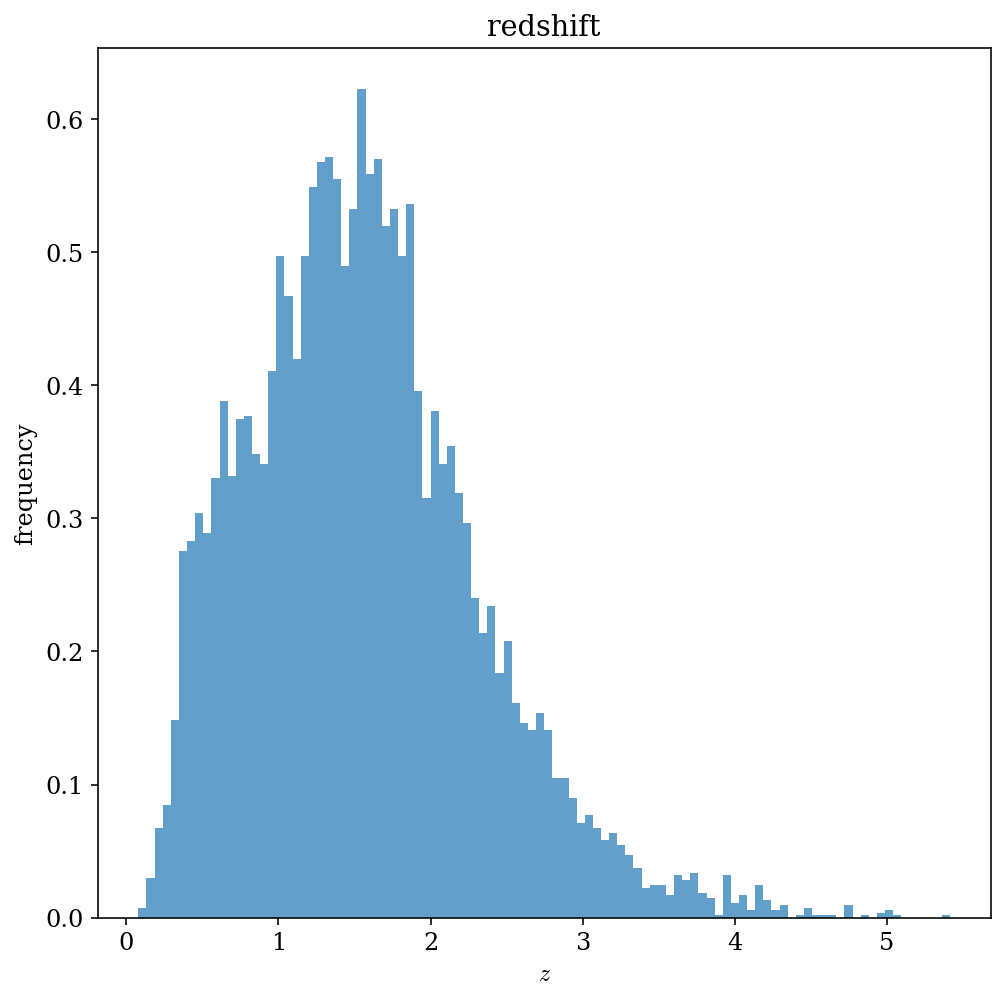

In [3]:
n, edges = np.histogram(z, bins = 100, density =True)
hist_z = scipy.stats.rv_histogram((n, edges))

plt.hist(z, bins = 100, density = True, alpha = 0.7)
plt.xlabel("$z$")
plt.ylabel("frequency")
plt.title('redshift')
plt.show()

# Rejection sampling

In [4]:
N_samples = int(1e4) #number of samples

In [5]:
#scipy method
cloned_data_scipy = hist_z.rvs(size = N_samples)

In [6]:
#explicit method
z_samples = np.random.uniform(0, edges.max(), N_samples)
n_samples = np.random.uniform(0, n.max(), N_samples)

mask = n_samples <= hist_z.pdf(z_samples)
cloned_data_rej = z_samples[mask]

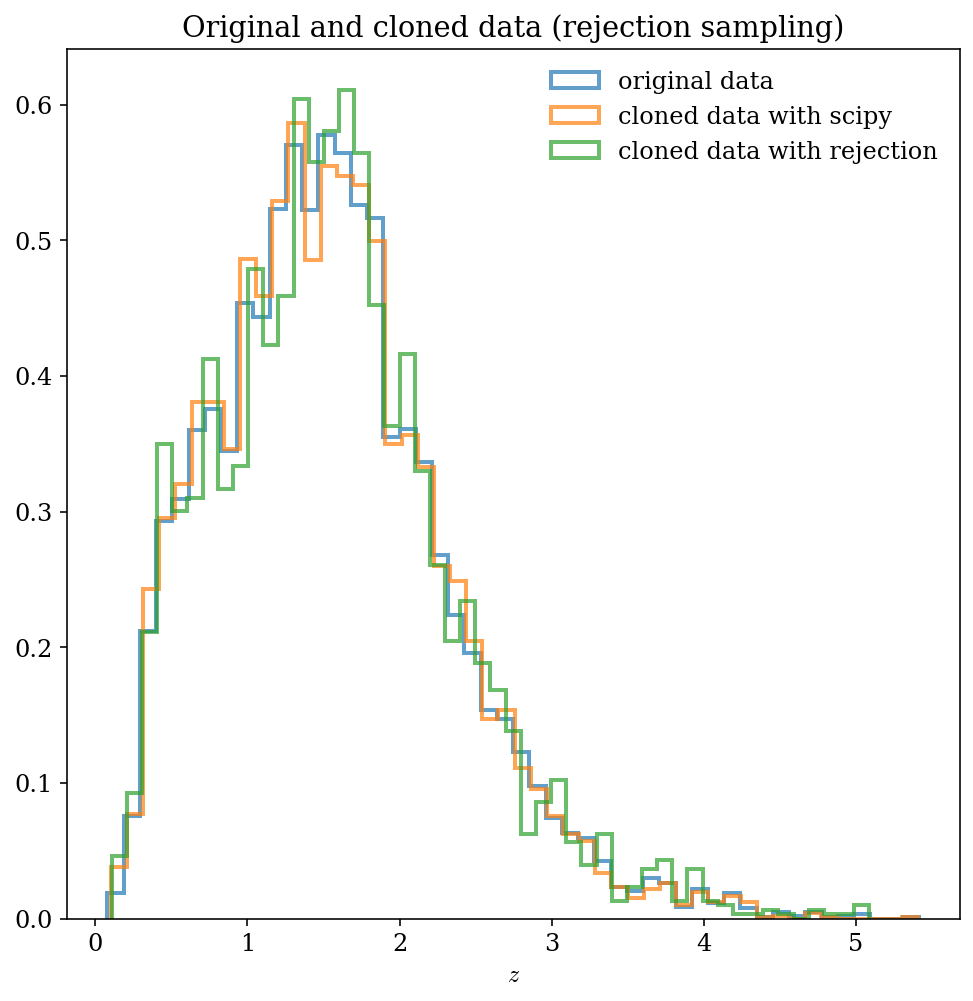

In [7]:
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'original data')
plt.hist(cloned_data_scipy, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'cloned data with scipy')
plt.hist(cloned_data_rej, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'cloned data with rejection')
plt.xlabel("$z$")
plt.title('Original and cloned data (rejection sampling)')
plt.legend(frameon = False)
plt.show()

# Inverse transformation

In [8]:
centers = (edges[1:] + edges[:-1]) / 2 #centers of the bins
cdf_sum = np.cumsum(n) / np.sum(n) #estimate of the cumulative sum

cdf = scipy.interpolate.interp1d(centers, cdf_sum) #cdf
cdf_inverse = scipy.interpolate.interp1d(cdf_sum, centers) #inverse of the cdf

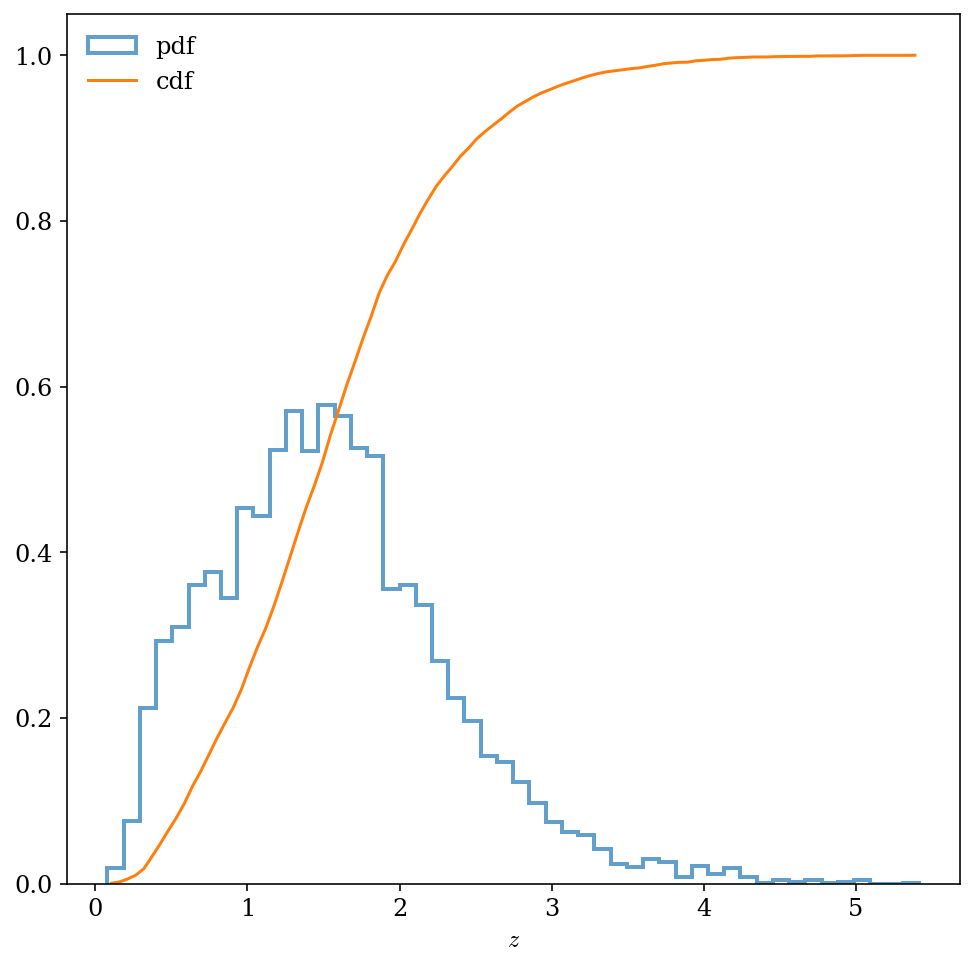

In [9]:
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'pdf')
plt.plot(centers, cdf(centers), label = 'cdf')
plt.xlabel('$z$')
plt.legend(frameon = False)
plt.show()

In [10]:
#sampling
p_samples = np.random.uniform(cdf_sum.min(), min(1, cdf_sum.max()), N_samples) #extrema such that the interpolation range is not exceeded
z_samples = cdf_inverse(p_samples)

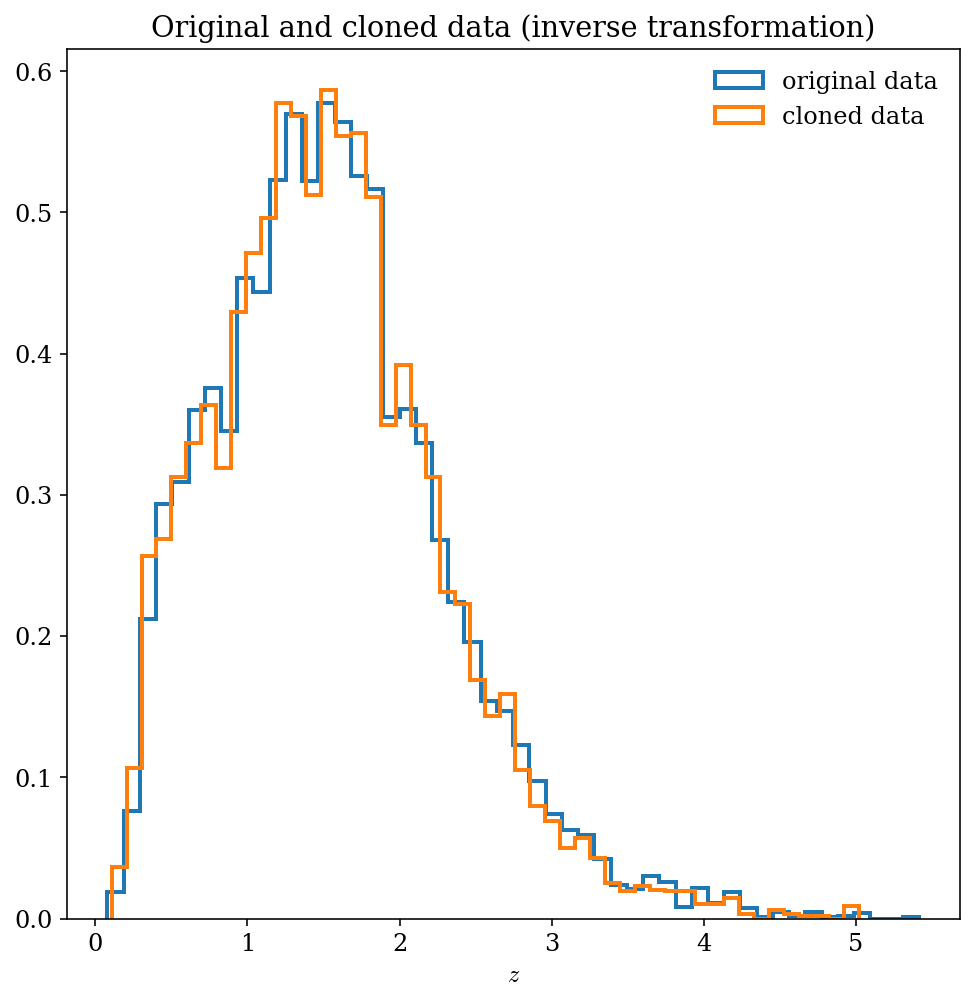

In [28]:
#plots
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2,label = 'original data')
plt.hist(z_samples, bins = 50, density = True, histtype = 'step', lw = 2, label = 'cloned data')
plt.xlabel("$z$")
plt.title('Original and cloned data (inverse transformation)')
plt.legend(frameon = False)
plt.show()

## implement a quantitative check: KS test

In [12]:
from scipy.stats import ks_2samp

In [13]:
ks_scipy, p_scipy = ks_2samp(z, cloned_data_scipy) #resample with scipy
ks_rej, p_rej = ks_2samp(z, cloned_data_rej) #rejection sampling
ks_inverse, p_inverse = ks_2samp(z, z_samples) #inverse transform

In [14]:
methods = ['scipy', 'rejection sampling', 'inverse transform']
ks_stats = [ks_scipy, ks_rej, ks_inverse]
p_stats = [p_scipy, p_rej, p_inverse]
for method, ks, p in zip(methods, ks_stats, p_stats):
    print(method + ': ks = %.4f, p-value = %.4f' % (ks,p))

scipy: ks = 0.0073, p-value = 0.9527
rejection sampling: ks = 0.0225, p-value = 0.1857
inverse transform: ks = 0.0124, p-value = 0.4255


# cosmology  
are the quasars uniformly distributed?

In [42]:
from astropy.cosmology import Planck15
from scipy.integrate import quad

In [59]:
cosmo = Planck15

z.sort()

Vc = lambda z: cosmo.differential_comoving_volume(z).value * 4*np.pi #comoving volume
integral = quad(Vc, 0, max(z))[0]
Vc_z = Vc(z) / integral #normalize 

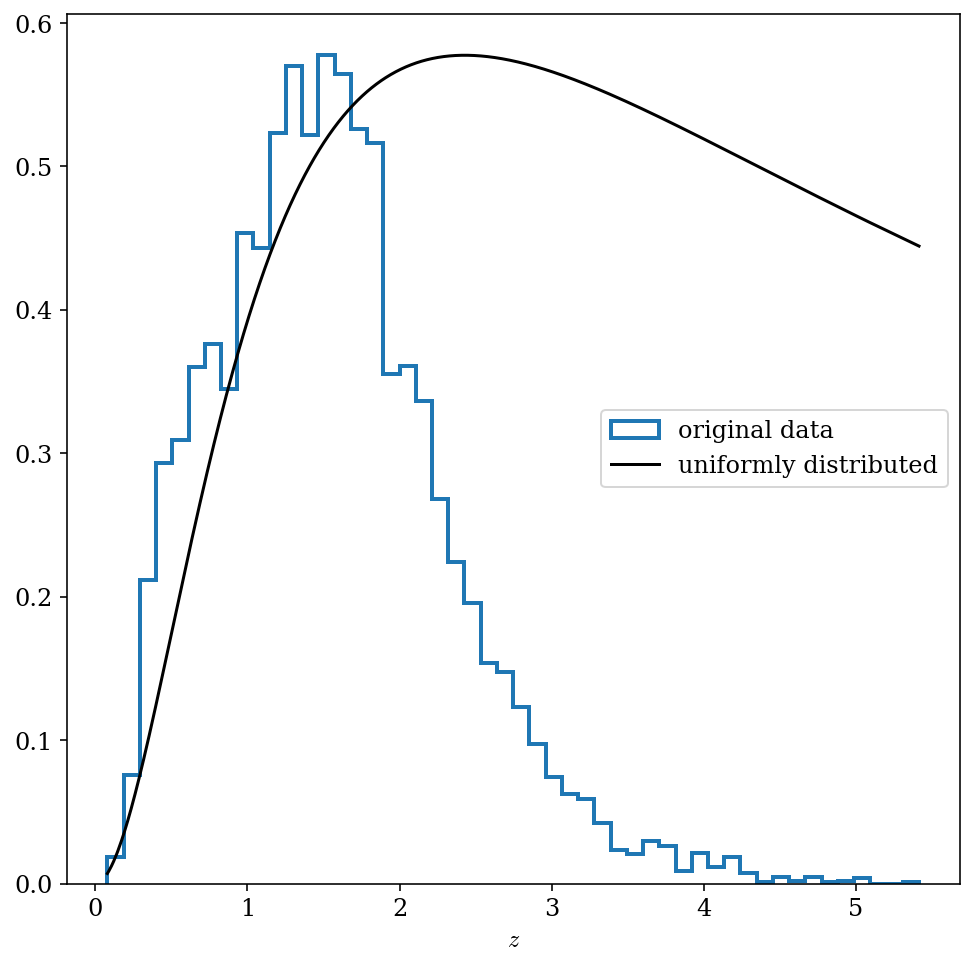

In [63]:
# plotting
H, _, _ = plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, color='C0', label = 'original data')
plt.plot(z, max(H)/ max(Vc_z) * Vc_z, c = 'k', label='uniformly distributed')

plt.xlabel(r'$z$')
plt.legend(loc='center right')
plt.show()

**not uniformly distributed**